# Word Vectors - Hands-On
Word vectors refers to a family of related techniques, first gaining popularity via ```Word2Vec``` which associates an $n$-dimensional vector (normally $n$ is in the range of $50$ to $500$) to every word in the target language.

We will first load a batch of word vectors known as [ConceptNet Numberbatch](https://github.com/commonsense/conceptnet-numberbatch), which have been found to have excellent performance while reducing issues of [learning human bias](https://gist.github.com/rspeer/ef750e7e407e04894cb3b78a82d66aed).  Learning how to construct these word vectors is a bit beyond the scope of what we can cover in this notebook, but [this two-part blog post provides an excellent introduction](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

__How to get the most from this notebook__:
This notebook builds out a solution in a step by step manner making it clear where data is being used and what tools are useful for exploration.  After every code block, I encourage you to explore your own problem from beginning to end using these tools.

In [2]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

! wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz

--2021-09-29 17:02:34--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.81.232
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.81.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269500348 (257M) [text/plain]
Saving to: ‘numberbatch-en-17.06.txt.gz’

numberbatch-en-17.0 100%[===================>] 257.01M  49.1MB/s    in 4.9s    

2021-09-29 17:02:39 (52.1 MB/s) - ‘numberbatch-en-17.06.txt.gz’ saved [269500348/269500348]



In [3]:
! rm -rf numberbatch-en-17.06.txt
! gzip -d numberbatch-en-17.06.txt.gz

In [26]:
# Load our libraries
import pandas as pd
import numpy as np

# Load word vectors
words = pd.read_csv('numberbatch-en-17.06.txt',
                    sep=" ",
                    index_col=0,
                    header=None,
                    skiprows=[0]).transpose()

The code snippet above loads our wordvectors.  The Pandas table ```words``` allows us to perform lookups like ```words['house']``` to get the associated vectors.  Let's just print one out for reference.

In [27]:
print(words['house'])

1      0.0331
2      0.1253
3      0.0865
4      0.0641
5     -0.1315
        ...  
296   -0.0046
297   -0.0053
298    0.0449
299   -0.0277
300   -0.0500
Name: house, Length: 300, dtype: float64


Try and print the word vectors for other words. Compare the vectors of similar words such as 'forest' & 'tree' vs 'painting' & 'pizza'.

In [44]:
# Implement code here

# Modified here to print the embeddings as vectors only showing first 8 elements to compare
print(words['forest'].values[:8])
print(words['tree'].values[:8])
print(words['painting'].values[:8])
print(words['pizza'].values[:8])

[-0.0385 -0.0072  0.1715  0.0654 -0.0774  0.1383  0.1382  0.2227]
[ 0.0168 -0.06    0.2282  0.1088 -0.0641  0.1765  0.116   0.0906]
[ 0.0392  0.0361  0.1195 -0.0144 -0.0317  0.1967  0.0025 -0.1554]
[-0.0116  0.0044  0.1192  0.1248 -0.0545 -0.0136  0.1977 -0.1692]


Such a vector is not particularly informative to us since it is not organized in a humanly readable way.

## Computing Distances
As part of our "manipulation primitives", we often need to be able to compute distances between vectors associated to words.  So we start by writing a little snippet that lets us do so.  ```numpy``` makes this fairly easy to do.  Remember that small distances correspond to similar words, so lets check this by going through and writing a little code that takes three words and tells you if the first word is closer to the second than the third.

In [7]:
# define the distance between two words
def dist(w1,w2) :
    return np.linalg.norm(words[w1] - words[w2])
    
# Say if w1 is closer to w2 than w3
def distCompare(w1, w2, w3) :
    d2 = dist(w1,w2)
    d3 = dist(w1,w3)
    if d2 < d3 :
        print("{} is closer to {} than {}".format(w1,w2,w3))
    else :
        print("{} is closer to {} than {}".format(w1,w3,w2))

Use the `distCompare` function to compare the following triplets:
- 'orb','ball','hockey'
- 'picked','lifted','play'
- 'pink','red','blue'

Do you agree with the results?

In [8]:
# Implement code here
distCompare('orb','ball','hockey')
distCompare('picked','lifted','play')
distCompare('pink','red','blue')

orb is closer to ball than hockey
picked is closer to lifted than play
pink is closer to red than blue


We see that it mostly agrees with what we anticipated.  If you continued to ask more questions, you'd find some things that disagree with what you would expect (for instance, it believes that ```'maroon'``` is closer to ```'blue'``` than ```'red'```), but on the whole, you'll find it agrees with the intuition that similar words should be close to one another. 

## Linear Structure of Word Vectors (Subtraction)

If word vectors only put similar words next to one another, they would have never garnered the interest that they have obtained from the community.  Indeed they actually contain subtle and nuanced understanding of the meanings of words.  It will take a while to explore what this means, but the mantra that we should now internalize is "relationships = directions" which is to say that words that share a similar relationship, will be separated from one another in the same direction.

As we saw, vector subtraction lets us examine this.  However, since vector subtraction is as simple as
```python
diff = v - w
```
there is not much to look at here.

## Reverse Lookup

Reverse lookup will allow us to probe the finer structure of word vectors.  In particular, we will now create a reverse lookup routine that finds the $k$ closest words to a given vector.  As the straight-forward implementation will be too slow (looping over every element of ```words```) we will provide you with a ```numpy``` implementation which will be fast enough for our needs.

In [10]:
# drop things containing underscores (these are compound terms like "young_man" that our code will not use) and convert to matrix format for faster computation
labels  = words.columns.values.tolist()
labels = np.array([w for w in labels if isinstance(w,str) and w.isalpha()])
wordsMatrix = words[labels].values

# snipped to find the closest word (or vector)
def find_closest_word(v, k = 1):
    if type(v) == type('str'):
        v = words[v]
    diff = wordsMatrix - v.values.reshape(-1,1)
    delta = np.linalg.norm(diff, axis=0)
    return labels[np.argsort(delta)[:k]]

Test the `find_closest_word` function with the 50 closest words to blue.

In [11]:
# implement code here
find_closest_word('blue', k = 50)

array(['blue', 'bluecurls', 'bluishness', 'bluer', 'unblue', 'bluest',
       'blueish', 'cyanol', 'bluely', 'gridelin', 'iridovirus',
       'ceruleous', 'roygbiv', 'cyanophore', 'lazuline', 'berylline',
       'acyanopia', 'bluing', 'blueness', 'chromostereopsis', 'umangite',
       'red', 'yellowred', 'bluet', 'bluetit', 'purple', 'yellow',
       'kumst', 'cerulean', 'purpre', 'mauvette', 'bepurple', 'bluish',
       'purpureal', 'pyrrh', 'deredden', 'indigoidine', 'zaffre', 'argb',
       'bloncket', 'turquoisey', 'puniceous', 'luteo', 'rubiform',
       'xanthous', 'xanthochromic', 'crustaceorubin', 'tetronerythrin',
       'vitellorubin', 'cyanophyll'], dtype='<U85')

You should now see lLots of blue related words, and then words related to other colors.  Many of them, like ```'tetronerythrin'``` actually relate to specific pigments.

# Application: Analogies

Let us suppose that we have four associated word vectors $v_{man}$, $v_{woman}$, $v_{boy}$, and $v_{girl}$.  If we believe the idea that "relationship = direction" then, this becomes a vector relationship, where the vector that takes us from $v_{man}$ to $v_{woman}$ should be the same as the vector that takes us from $v_{boy}$ to $v_{girl}$.  Recalling that vector subtraction is what gives us such a direction, this becomes
$$
v_{woman} - v_{man} \approx v_{girl} - v_{boy}
$$

Suppose you now wanted to solve an analogy using this idea.  Say we were just given ```man:woman::boy:?``` and we wanted to find the question mark.  The expression above can be rearranged by adding $v_{boy}$ to both sides to yield
$$
v_{?} \approx v_{woman} - v_{man} + v_{boy}
$$
Thus the word we are looking for should hopefully be the word whose associated vector is closest to $v_{woman} - v_{man} + v_{boy}$.  Let's see how this works out in code.

In [13]:
# A little snippet for analogies
def analogy(w1,w2,w3, k = 1) : 
    listPoss = find_closest_word(words[w2] - words[w1] + words[w3], k)
    print("{} : {} :: {} : {}".format(w1,w2,w3,listPoss))

Use the `analogy` function to create associated vectors. Find the 2 closest examples for:
- 'man','woman','boy'
- 'short', 'tall', 'shortest'
- 'seattle','washington','minneapolis'

In [14]:
# implement code here
analogy('man','woman','boy', k = 2)
analogy('short', 'tall', 'shortest', k = 2)
analogy('seattle','washington','minneapolis', k = 2)

man : woman :: boy : ['girl' 'boy']
short : tall :: shortest : ['tallest' 'tall']
seattle : washington :: minneapolis : ['minnesota' 'minneapolis']


All in all, this should have worked fantastically!  The first one will indeed show that ```man : woman :: boy : girl``` as the most likely choice. The second will state that ```short : tall :: shortest : tallest``` is the most likely case indicating that it understands how to turn words into superlatives (not just a simple relationship of size).  The third one indicates it understands what the largest cities in Washington and Minnesota are and can retrieve that information if needed.

## Visualization (PCA)

Let's implement our last little primitive: the ability to automatically visualize what a collection of vectors is doing by projecting it onto the best possible pair of directions.  We will use [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to do this.

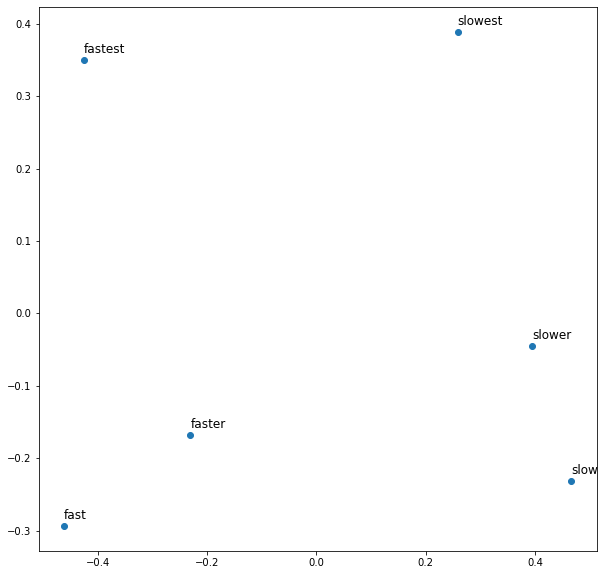

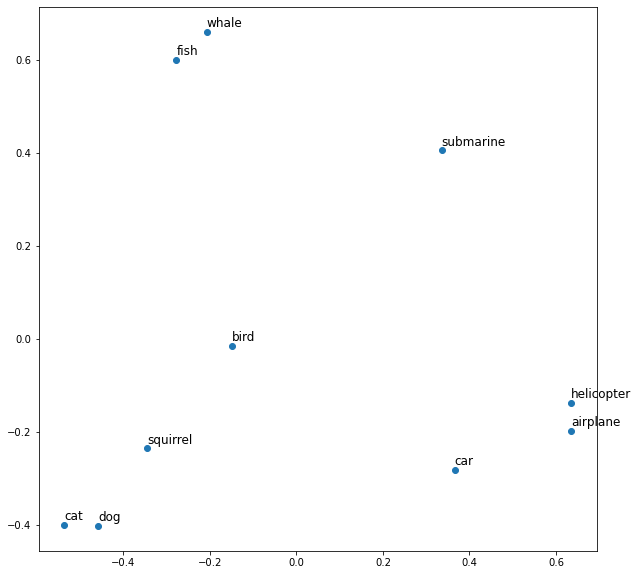

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pcaPlot(word_list) :
    # fetch list of word vectors
    vecs = [words[x] for x in word_list]
    
    #reduce dimensions
    model = PCA(n_components = 2)
    reduced = model.fit_transform(vecs)
    xc = [v[0] for v in reduced]
    yc = [v[1] for v in reduced]
    
    # plot them
    plt.figure(figsize=(10,10))
    plt.scatter(xc, yc)

    # label the plot
    for i, word in enumerate(word_list) :
    	plt.annotate(word, xy=(xc[i], yc[i]+0.01), fontsize=12)
    plt.show()

pcaPlot(['fast','faster','fastest','slow','slower','slowest'])
pcaPlot(['bird', 'cat', 'squirrel', 'dog', 'fish', 'helicopter', 'airplane', 'car', 'submarine', 'whale'])

In [ ]:
# Deleting notebook artifacts to free up memory
! rm -rf numberbatch-en-17.06.txt.gz
! rm numberbatch-en-17.06.txt

## Word Embeddings with BERT

This section of the notebook provides a short example of installing GluonNLP, and then using a pretrained BERT model to encode a sentence.  This can be used as an encoding method for any other downstream learning algorithm, and is an excellent method to use during early stages of product development.  If the application seems sound, the model can be fine-tuned for additional performance.  Scripts to aid in this task can be found [here](https://gluon-nlp.mxnet.io/master/model_zoo/bert/index.html).

In [23]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

# Load Relevant Libraries
!pip install --upgrade pip
!pip install --upgrade mxnet gluonnlp

import warnings
warnings.filterwarnings('ignore')

In [17]:
import gluonnlp as nlp
import mxnet as mx

# Load a Small BERT model
model, vocab = nlp.model.get_model('bert_12_768_12', dataset_name='book_corpus_wiki_en_uncased', use_classifier=False, use_decoder=False);
tokenizer = nlp.data.BERTTokenizer(vocab, lower=True);
transform = nlp.data.BERTSentenceTransform(tokenizer, max_seq_length=512, pair=False, pad=False);

# Transform Text
sample = transform(['AWS Embark provides onboarding, training, and implementation support to launch your machine learning journey!']);
words, valid_len, segments = mx.nd.array([sample[0]]), mx.nd.array([sample[1]]), mx.nd.array([sample[2]]);

# Encode
seq_encoding, cls_embedding = model(words, segments, valid_len);

The first step of using a transformer is to split the sentence into tokens for a vocabulary.  This is handled cleanly by Gluon, but we can look inside to see how it is split.  Notice that the model actually uses a subword vocabulary---where some words are split into constituant parts like "onboarding" becoming `'onboard'` and `'##ing'`.

In [18]:
[vocab.to_tokens(int(w.asscalar())) for w in words[0]]

['[CLS]',
 'aw',
 '##s',
 'embark',
 'provides',
 'onboard',
 '##ing',
 ',',
 'training',
 ',',
 'and',
 'implementation',
 'support',
 'to',
 'launch',
 'your',
 'machine',
 'learning',
 'journey',
 '!',
 '[SEP]']

We can now look at an embedding that can be used for downstream tasks like classification, called the `cls_embedding`.  The other term `seq_encoding` gives an encoding for each token in the sentence and can be used for tasks like machine translation or part-of-speach tagging.

In [19]:
# print the first few elements of cls_embedding
cls_embedding[0][:10]


[-0.93319315 -0.6459555  -0.9838874   0.87455887  0.83370495 -0.27255702
  0.8364643   0.5017097  -0.96900386 -0.99999803]
<NDArray 10 @cpu(0)>

In [20]:
# print the first few elements of seq_embedding
seq_encoding[0][:10]


[[-8.0721870e-02 -3.1244898e-01 -2.7855474e-01 ... -3.3205980e-01
   6.4457864e-02  3.3107305e-01]
 [ 1.8127954e-01  4.5019066e-01 -3.1973413e-01 ...  1.5032892e-02
   9.8940516e-01 -5.7431811e-01]
 [-7.9789227e-01 -1.6274306e-01  4.0670854e-01 ...  4.9875475e-02
  -1.5348536e-01 -2.6935045e-02]
 ...
 [-1.7599177e-01  6.3371402e-01  1.1434132e+00 ... -6.4493769e-01
  -2.4177554e-01 -7.5432885e-01]
 [ 9.3114190e-04 -4.7318268e-01  8.2199037e-01 ... -6.1275935e-01
  -2.5028262e-01 -3.6183149e-01]
 [ 2.8646764e-01  4.1624576e-01 -1.1986467e-01 ... -2.5453246e-01
  -8.2297385e-01 -3.6215851e-01]]
<NDArray 10x768 @cpu(0)>

Convert your own sample sentence to vectors for a sentiment classification task.

In [21]:
# implement code here

# Transform Text
sample = transform(['Im testing this new sentence.']);
words, valid_len, segments = mx.nd.array([sample[0]]), mx.nd.array([sample[1]]), mx.nd.array([sample[2]]);

# Encode
seq_encoding, cls_embedding = model(words, segments, valid_len);

In [46]:
seq_encoding, cls_embedding

(
 [[[-0.05273714  0.4541449  -0.33006734 ... -0.6942834   0.321104
     0.6141347 ]
   [ 0.229097    0.42749238  1.3776906  ... -0.3775384   0.24434547
     0.6825533 ]
   [ 0.6804513  -0.20249692 -0.2256034  ... -0.4475162  -0.21928316
    -0.17017382]
   ...
   [ 0.5764747  -0.1246152   0.2587098  ... -0.11493178 -0.4287983
    -0.00526207]
   [ 0.26712582  0.22507876 -0.25183925 ...  0.09260296 -0.21821204
    -0.7370999 ]
   [ 0.82899344  0.34104496 -0.09680615 ...  0.13682619 -0.5380728
    -0.3718049 ]]]
 <NDArray 1x8x768 @cpu(0)>,
 
 [[-0.9628504  -0.5380673  -0.96253663  0.8976082   0.7942141  -0.34756765
    0.94662565  0.2909163  -0.92727524 -0.99999714 -0.51362395  0.9690095
    0.9866746   0.6891499   0.9543912  -0.8881327  -0.7300077  -0.6519327
    0.2883492  -0.8396616   0.77239746  0.99999887 -0.06553265  0.28556234
    0.5757641   0.9978224  -0.8514754   0.96042657  0.9801772   0.816268
   -0.8572227   0.24523038 -0.993754   -0.23924473 -0.9528073  -0.99473715
    0.5